In [1]:
from src.dataset.phonetic_pair_dataset import PhoneticPairDataset
from src.model.sound_siamese import SoundSiamese
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.utilities.seed import seed_everything

from torch.utils.data import DataLoader
from pytorch_lightning import Trainer 

from typing import List
from eng_to_ipa import convert

seed_everything(0)

c:\Users\simon\anaconda3\envs\Mnemo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


0

# Model Training

In [2]:
mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./mlruns")
dataset = PhoneticPairDataset(best_pairs_path='best_pairs.csv', worst_pairs_path='worst_pairs.csv')
model = SoundSiamese()
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
trainer = Trainer(max_epochs=100, logger=mlf_logger)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Experiment with name lightning_logs not found. Creating it.

  | Name      | Type                    | Params
------------------------------------------------------
0 | embedding | Embedding               | 9.4 K 
1 | encoder   | TransformerEncoderLayer | 68.8 K
------------------------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.313     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 196/196 [00:02<00:00, 70.06it/s, loss=0.388, v_num=bdf3, Loss_step=0.500, Loss_epoch=0.361]   


# Saving model

In [5]:
import torch
from pathlib import Path

torch.save(model.state_dict(), "model_dict")

# Visualization

In [18]:
import umap
import matplotlib.pyplot as plt
import numpy as np
reducer = umap.UMAP()

## Embedding visualization

Text(0.5, 1.0, 'UMAP projection of the Embeddings')

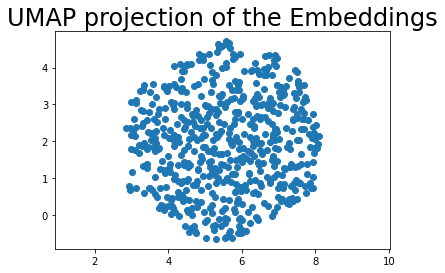

In [7]:
embedding_w = model.embedding.weight.detach().numpy()
embedding_u = reducer.fit_transform(embedding_w)

plt.scatter(
    embedding_u[:, 0],
    embedding_u[:, 1]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Embeddings', fontsize=24)

## Encoding viusalization

Text(0.5, 1.0, 'UMAP projection of the Embeddings')

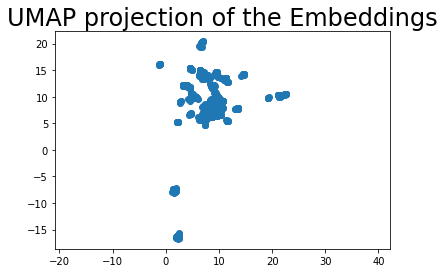

In [19]:
viz_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
embedding_w = np.array([x.detach().numpy() for x in model.encode([x['english_phonetic'][0] for x in iter(viz_dataloader)])])

embedding_u = reducer.fit_transform(embedding_w)

plt.scatter(
    embedding_u[:, 0],
    embedding_u[:, 1]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Word Encodings', fontsize=24)

# Inference

In [8]:
def load_model():
    model = SoundSiamese()
    model.load_state_dict(torch.load("model_dict"))

def convert_eng_to_ipa(word: str):
    return (
        convert(word, keep_punct=False)
        .replace("ˈ", "")
        .replace("ˌ", "")
        .replace(" ", "")
    )

def encode_english(words: List[str]):
    ipas = [convert_eng_to_ipa(w) for w in words]
    return model.encode(ipas) 

In [13]:
a, b, c, d = encode_english(['cat', 'dog',  'dodge', 'chat'])

In [14]:
torch.dot(a, b)

tensor(14.7442, grad_fn=<DotBackward0>)

In [15]:
torch.dot(a, c)

tensor(-7.8369, grad_fn=<DotBackward0>)

In [16]:
torch.dot(a, d)

tensor(11.1203, grad_fn=<DotBackward0>)